In [1]:
!pip list

Package                 Version
----------------------- -----------------------
absl-py                 0.15.0
appnope                 0.1.2
argon2-cffi             19.1.0
astunparse              1.6.3
attrs                   21.2.0
backcall                0.2.0
beniget                 0.3.0
bleach                  4.1.0
cached-property         1.5.2
cachetools              4.2.4
certifi                 2021.10.8
cffi                    1.15.0
charset-normalizer      2.0.7
cycler                  0.11.0
Cython                  0.29.24
debugpy                 1.5.1
decorator               5.1.0
defusedxml              0.7.1
entrypoints             0.3
flatbuffers             2.0
gast                    0.4.0
google-auth             2.3.2
google-auth-oauthlib    0.4.6
google-pasta            0.2.0
grpcio                  1.33.2
h5py                    2.10.0
idna                    3.3
imageio                 2.10.1
ipykernel               6.5.0
ipython                 7.29.0
ipython-gen

In [14]:
%matplotlib inline 

import numpy as np
import sklearn
import matplotlib
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt 
from sklearn import linear_model as lm
import seaborn as sns
import warnings
from numpy.linalg import inv, svd
warnings.filterwarnings('ignore')

In [15]:
for i in range(1,59):
    A = pd.read_csv('../../data/basis_vecs_scaled_color_{}.csv'.format(i))
    A = np.array(A)
    A = np.delete(A, 0, axis=1)
    A_8 = A[:,0:8]
    A_8_df = pd.DataFrame(A_8)
    A_8_df.to_csv('../../data/8_basis_vecs_scaled_color_{}.csv'.format(i)) ### save just the first 8 right singular vectors for each color holdout

In [16]:
A = pd.read_csv('../../data/basis_vecs_scaled.csv') ### Load singular vectors computed from full dataset
ratings= pd.read_csv('../../data/uw_58_ratings_matrix_unscaled.csv') ### Load ratings matrix
c_means = pd.read_csv('../../data/col_means.csv')  ### Load a vector of column means 

In [17]:
A = np.array(A)
A = np.delete(A, 0, axis=1)
A_8 = A[:,0:8]
A_8_df = pd.DataFrame(A_8)
A_8_df.to_csv('../../data/8_basis_vecs_scaled.csv') ### save just the first 8 right singular vectors for full dataset

## Interlude to see how many dims we need

In [18]:
factor_mat = pd.read_csv('../../data/factor_vecs_scaled.csv') ### left singular values
factor_mat = np.array(factor_mat)
factor_mat = np.delete(factor_mat, 0, axis=1)

In [19]:
concept_ratings = ratings.iloc[:,1:59]
concept_ratings = np.array(concept_ratings)
#concept_ratings = concept_ratings-c_means.V1.values

In [20]:
rng = np.random.default_rng()

test = concept_ratings - c_means.V1.values
shuffle_test = concept_ratings - c_means.V1.values
shuffle_test = rng.permuted(shuffle_test)
shuf_u, shuf_s, shuf_vt = svd(shuffle_test, full_matrices=False)
factor_mat_shuf = shuf_u@np.diag(shuf_s)


In [21]:
A.shape


(58, 30)

In [22]:


n_comp = []
r =[]
r_shuf = []
from scipy.stats.stats import pearsonr 
for i in range(1,30): ### concept
    for j in range(1,30): ### ncomps
        r.append(pearsonr(np.matmul(factor_mat[:,0:j+1],A.T[0:j+1,:])[i,],test[i,])[0])
        r_shuf.append(pearsonr(np.matmul(factor_mat_shuf[:,0:j+1],shuf_vt[0:j+1,:])[i,],shuffle_test[i,])[0])
        n_comp.append(j)
        
cor_df = pd.DataFrame({'n_comp':n_comp,'r':r,'r_shuf':r_shuf})


Text(0.5, 1.0, 'Shuffled vs unshuffled reconstructions')

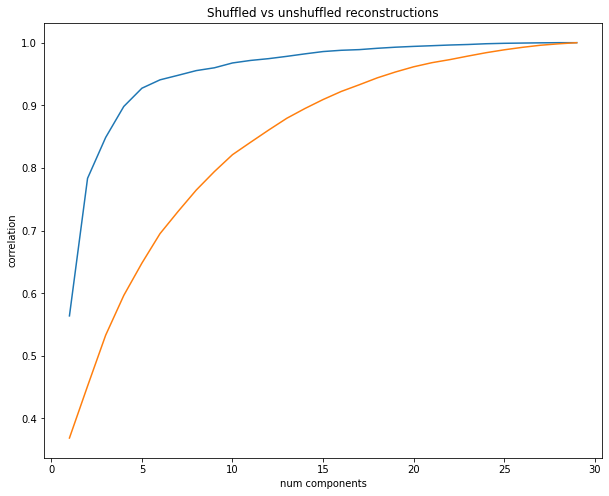

In [23]:
summary_cor_df = cor_df.groupby(n_comp).mean().reset_index()

plt.figure(figsize=(10,8))
plt.plot(np.arange(1,30),summary_cor_df.r)
plt.plot(np.arange(1,30),summary_cor_df.r_shuf)
plt.xlabel('num components')
plt.ylabel('correlation')
plt.title('Shuffled vs unshuffled reconstructions')

### Choosing colors to estimate new concepts

In [24]:

##high low col inds

#color_inds = [4, 22, 23, 26, 29, 32, 53, 56]#CVXOPT 
#color_inds = [3, 4, 8, 22, 23, 24, 26, 53] #SCS
#color_inds=[0, 2, 3, 13, 22, 23, 26, 27, 32, 36, 49, 53, 55, 57] ## * best
#color_inds=[0, 2, 3, 13, 22, 23, 32, 49, 53, 55, 57] ##

#color_inds = [1,  7,  8, 12, 14, 19, 27, 28, 31, 33, 38, 46, 53] ## from R top and bottom
#color_inds = [1,  2,  8, 12, 14, 19, 26, 27, 28, 33, 35, 36, 38, 39, 55] ##top 2
#color_inds = [x - 1 for x in color_inds]


### new as of 2021

color_inds = [4, 21, 22, 23, 24, 26, 32, 38, 49, 50, 53, 54, 56, 57]


## No Holdout reconstructions

### no holdout for both

In [25]:
conc_prof_mat = np.zeros(shape=(30,5)) ## 5 concepts only for now/ this matrix holds the approximated factor matrix 

cors = []
L2s = []
for i in range(ratings.shape[0]):
    concept_ratings = ratings.iloc[i][1:59]
    concept_ratings = np.array(concept_ratings)
    concept_ratings = concept_ratings-c_means.V1.values
    reg = lm.LinearRegression().fit(A_8[color_inds,:5], concept_ratings[color_inds])
    #reg = lm.LinearRegression().fit(A_8, concept_ratings)
    coords = reg.coef_[0:5]   ## only use 5 components
    recon = np.matmul(A_8[:,:5],coords)
    cors.append(np.corrcoef(recon.astype(float),concept_ratings.astype(float))[0,1])
    conc_prof_mat[i,:] = coords
               

In [26]:
ratings.iloc[:,0].values

array(['dress', 'pants', 'shirt', 'shoes', 'socks', 'above', 'below',
       'beside', 'far', 'near', 'angry', 'disgust', 'fearful', 'happy',
       'sad', 'blueberry', 'lemon', 'mango', 'strawberry', 'watermelon',
       'beach', 'field', 'ocean', 'sky', 'sunset', 'dawn', 'day', 'dusk',
       'night', 'noon'], dtype=object)

In [27]:
no_concept_holdout= pd.DataFrame(list(zip(list(ratings.iloc[:,0]),cors)), columns = ['concept','correlation'])

In [28]:
np.mean(cors)

0.8765774420717047

Text(0.5, 1.0, 'Reconstruction using 5 principal components')

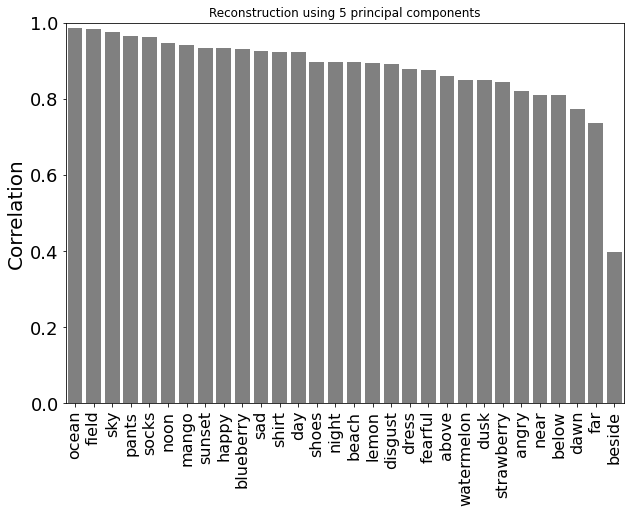

In [29]:
no_concept_holdout = no_concept_holdout.sort_values(['correlation'],ascending=False).reset_index(drop=True)
fig = plt.figure(figsize=(10,7))
sns.barplot(no_concept_holdout.concept, no_concept_holdout.correlation, edgecolor = 'none', color='gray')
#plt.axis('off')
#plt.xticks([])
plt.xticks(rotation = 90, fontsize= 16)
plt.xlabel('')
plt.yticks(fontsize=18)
plt.ylabel('Correlation', fontsize=20)
plt.ylim(0,1)
ax = plt.gca()
#ax.set_facecolor((0.3497,0.3497,0.3497))
ax.set_facecolor((1,1,1))
plt.title("Reconstruction using 5 principal components")
# plt.savefig('concept_holdout.pdf',format ='pdf',bbox_inches='tight')
# plt.show()

In [30]:
## conc_prof_mat is a matrix of estimated factor scores (normally left singular vecs times singular values)
color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy()
prof_coef_mat = pd.read_csv('../../data/10_regression_weights.csv',header=None).to_numpy()[:,:5] ## first 5 components

In [31]:
approx_recon = conc_prof_mat@(prof_coef_mat.T@color_coord_mat)

In [32]:
approx_cors = []
for i in range(approx_recon.shape[0]):
    concept_ratings = ratings.iloc[i][1:59]
    concept_ratings = np.array(concept_ratings)
    concept_ratings = concept_ratings-c_means.V1.values
    approx_cors.append(np.corrcoef(approx_recon[i,:].astype(float),concept_ratings.astype(float))[0,1])

approx_df = pd.DataFrame(list(zip(list(ratings.iloc[:,0]),approx_cors)), columns = ['concept','correlation'])

Text(0.5, 1.0, 'Reconstruction using approximations of both matrices with no holdout')

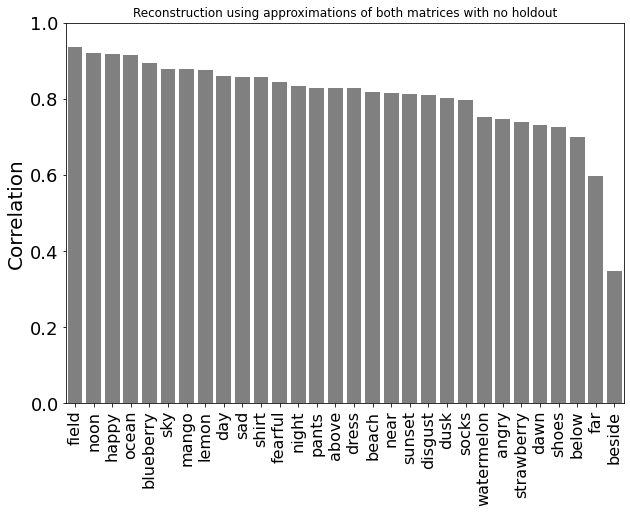

In [33]:
approx_df = approx_df.sort_values(['correlation'],ascending=False).reset_index(drop=True)
fig = plt.figure(figsize=(10,7))
sns.barplot(approx_df.concept, approx_df.correlation, edgecolor = 'none', color='gray')
#plt.axis('off')
#plt.xticks([])
plt.xticks(rotation = 90, fontsize= 16)
plt.xlabel('')
plt.yticks(fontsize=18)
plt.ylabel('Correlation', fontsize=20)
plt.ylim(0,1)
ax = plt.gca()
#ax.set_facecolor((0.3497,0.3497,0.3497))
ax.set_facecolor((1,1,1))
plt.title("Reconstruction using approximations of both matrices with no holdout")
# plt.savefig('concept_holdout.pdf',format ='pdf',bbox_inches='tight')
# plt.show()

In [34]:
np.mean(approx_cors)

0.8046523620538438

In [35]:
approx_df

,concept,correlation
0,field,0.935533
1,noon,0.919561
2,happy,0.917498
3,ocean,0.915373
4,blueberry,0.892678
5,sky,0.877961
6,mango,0.877824
7,lemon,0.876181
8,day,0.860743
9,sad,0.858195


## Holdout methods

In [36]:
concept_list = ratings.iloc[:,0].values

### Leave one out (concept)

In [56]:
num_pcs =[]
con_reg_cors = []
cons = []
for num_pc in range(10):

  
 
    for this_concept in concept_list:
        ratings_sub = ratings[~ratings.iloc[:,0].isin([this_concept])]
        A = pd.read_csv('../../data/basis_vecs_scaled_{}.csv'.format(this_concept))
        A = np.array(A)
        #A = np.delete(A, 0, axis=1)
        A = A[:,0:num_pc+1]
        concept_ratings = np.array(ratings[ratings.iloc[:,0].isin([this_concept])].iloc[:,1:59])-c_means.V1.values
        #reg = lm.LinearRegression().fit(A[color_inds,:], concept_ratings.squeeze(0)[color_inds])
        reg = lm.LinearRegression().fit(A, concept_ratings.squeeze(0))
        coords = reg.coef_[:num_pc+1]
        recon = np.matmul(A[:,:num_pc+1],coords)
        con_reg_cors.append(np.corrcoef(recon.astype(float),concept_ratings.squeeze(0).astype(float))[0,1])
        num_pcs.append(num_pc+1)
        cons.append(this_concept)


In [57]:
holdout_con_cors = pd.DataFrame(list(zip(cons, num_pcs, con_reg_cors)),columns=['concept','num_pc','holdout_cor'])

In [58]:
holdout_con_cors.groupby('num_pc').std().reset_index().holdout_cor/np.sqrt(30)*1.96

0    0.068959
1    0.056654
2    0.046523
3    0.047095
4    0.031591
5    0.026599
6    0.025440
7    0.023921
8    0.023698
9    0.023595
Name: holdout_cor, dtype: float64

In [60]:
plot_ys

0    0.332734
1    0.527369
2    0.754649
3    0.812422
4    0.869911
5    0.905654
6    0.917781
7    0.922624
8    0.928713
9    0.931147
Name: holdout_cor, dtype: float64

Text(0, 0.5, 'correlation')

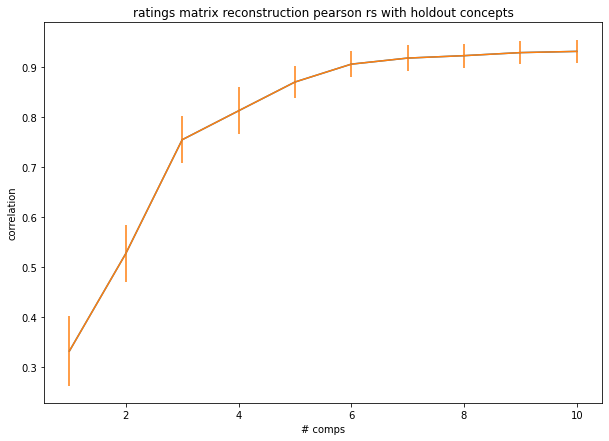

In [59]:
plot_ys = holdout_con_cors.groupby('num_pc').mean().reset_index().holdout_cor
plot_err = holdout_con_cors.groupby('num_pc').std().reset_index().holdout_cor/np.sqrt(30)*1.96
fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(1,11),plot_ys)
plt.errorbar(x= np.arange(1,11),y = plot_ys,yerr=plot_err)
plt.title('ratings matrix reconstruction pearson rs with holdout concepts')
plt.xlabel('# comps')
plt.ylabel('correlation')

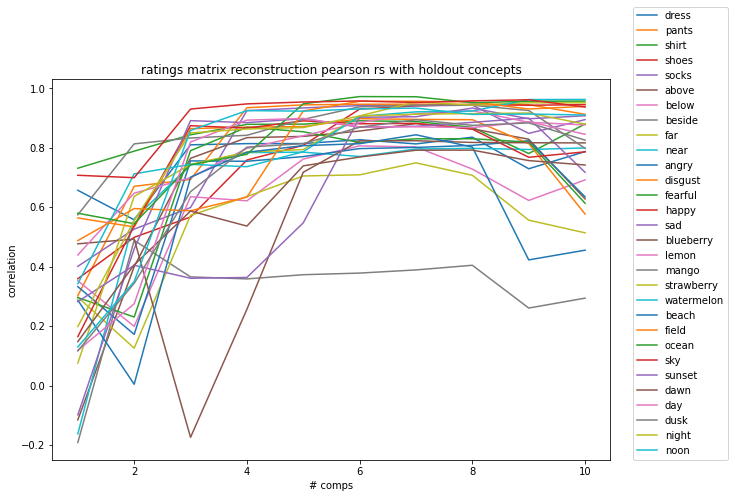

In [38]:
plt.figure(figsize=(10,7))
for this_concept in concept_list:
    plot_ys = holdout_con_cors[holdout_con_cors.concept==this_concept].holdout_cor
    plt.plot(np.arange(1,11),plot_ys, label=this_concept)
    plt.title('ratings matrix reconstruction pearson rs with holdout concepts')
    plt.xlabel('# comps')
    plt.ylabel('correlation')
    plt.legend(loc=(1.04,0))
plt.show()

In [39]:
plot_ys

29     0.129760
59     0.349714
89     0.857713
119    0.924396
149    0.922548
179    0.929954
209    0.932932
239    0.911638
269    0.912785
299    0.909621
Name: holdout_cor, dtype: float64

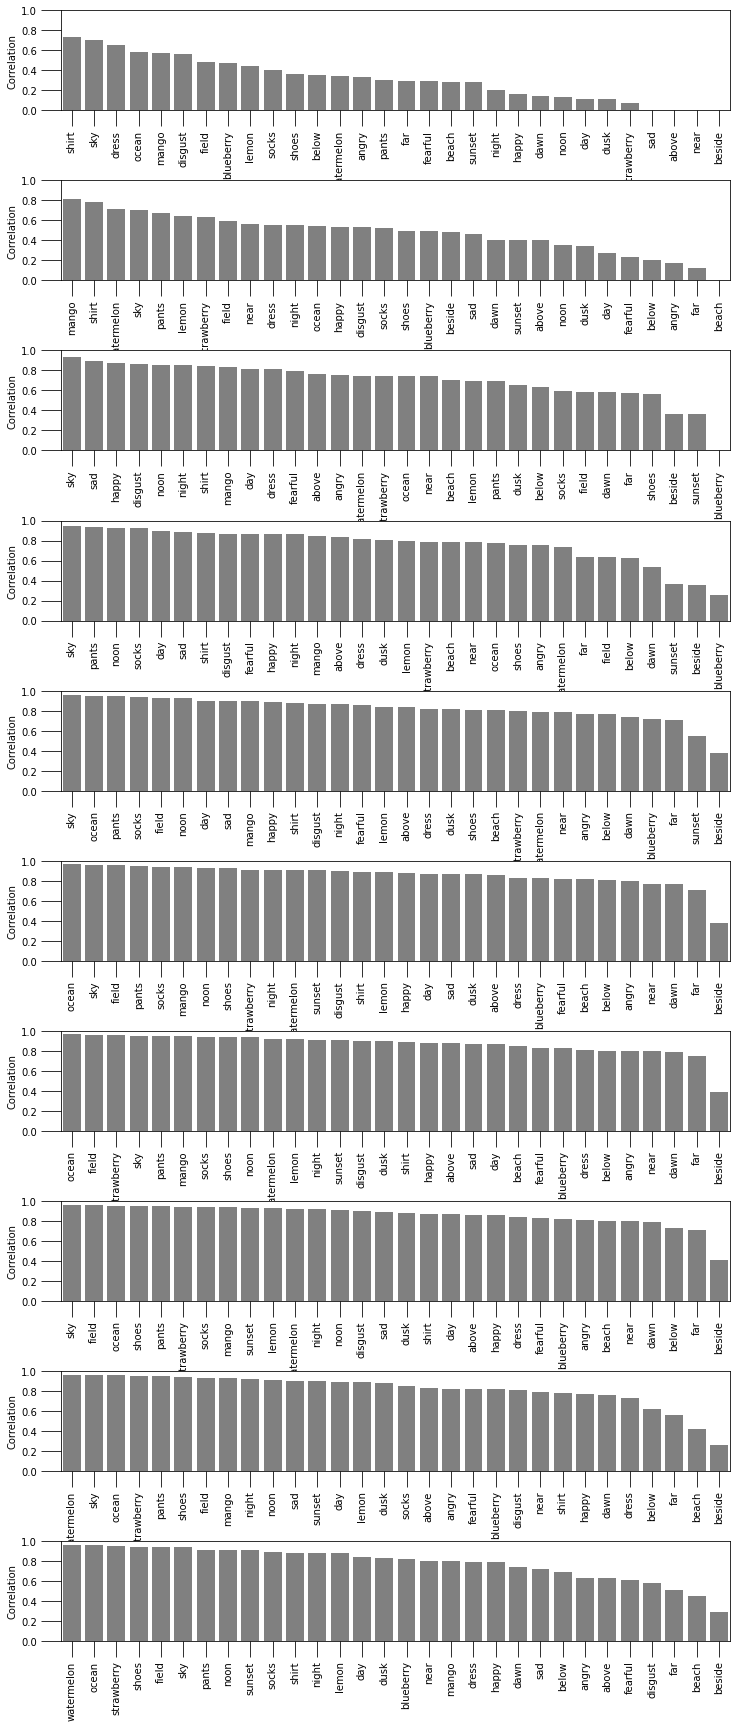

In [40]:

fig, ax = plt.subplots(10,1, figsize=(12,30))

fig.subplots_adjust(hspace=.7)

for i in range(1,11):
    concept_holdout = holdout_con_cors[holdout_con_cors.num_pc==i]

    concept_holdout = concept_holdout.sort_values(['holdout_cor'],ascending=False).reset_index(drop=True)

    sns.barplot(ax=ax[i-1],x= concept_holdout.concept, y= concept_holdout.holdout_cor, edgecolor = 'none', color='gray')
    #plt.axis('off')
    #plt.xticks([])
    #x[i].xticks(rotation = 90, fontsize= 16)
    ax[i-1].tick_params(axis='x',labelrotation=90, size=16)
    ax[i-1].set_xlabel('')
    ax[i-1].tick_params(axis='y', size=20)
    ax[i-1].set_ylabel('Correlation')
    ax[i-1].set_ylim(0,1)
    #ax = plt.gca()
    #ax.set_facecolor((0.3497,0.3497,0.3497))
    ax[i-1].set_facecolor((1,1,1))
    #plt.title("Reconstruction correlations while leaving out one concept at a time")
    # plt.savefig('concept_holdout.pdf',format ='pdf',bbox_inches='tight')
    # plt.show()

In [41]:
# concept_holdout = concept_holdout.sort_values(['correlation'],ascending=False).reset_index(drop=True)
# fig = plt.figure(figsize=(10,7))
# sns.barplot(concept_holdout.concept, concept_holdout.correlation, edgecolor = 'none', color='gray')
# #plt.axis('off')
# #plt.xticks([])
# plt.xticks(rotation = 90, fontsize= 16)
# plt.xlabel('')
# plt.yticks(fontsize=18)
# plt.ylabel('Correlation', fontsize=20)
# plt.ylim(0,1)
# ax = plt.gca()
# #ax.set_facecolor((0.3497,0.3497,0.3497))
# ax.set_facecolor((1,1,1))
# plt.title("Reconstruction correlations while leaving out one concept at a time")
# # plt.savefig('concept_holdout.pdf',format ='pdf',bbox_inches='tight')
# # plt.show()

In [42]:
# np.mean(cors)

## Color generalization

In [101]:
assoc_mat = np.array(pd.read_csv('../../data/uw_58_ratings_matrix_unscaled.csv'))[:,1:]
assoc_mat = assoc_mat.astype('float')
assoc_mat_c = assoc_mat- c_means.V1.values
U,S,Vh = svd(assoc_mat_c, full_matrices=False)
v_sub = Vh[0:10,]
conc_prof_mat= U @ np.diag(S) ### actual ground truth factor matrix


component 1 when there are 10 components: 0.9259460041177533
component 2 when there are 10 components: 0.9018020649712754
component 3 when there are 10 components: 0.9463378253382649
component 4 when there are 10 components: 0.8649298463474977
component 5 when there are 10 components: 0.9336072185613258
component 6 when there are 10 components: 0.7069474367733067
component 7 when there are 10 components: 0.5726708010202106
component 8 when there are 10 components: 0.2792722245518209
component 9 when there are 10 components: 0.6186250127417133
component 10 when there are 10 components: 0.20145925501642908


Text(0, 0.5, 'correlation')

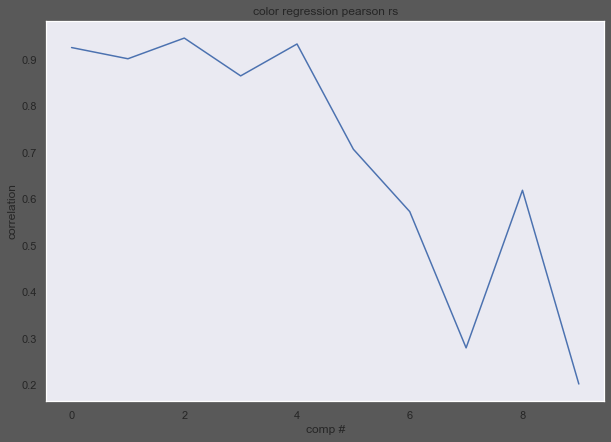

In [102]:
prof_coef_mat = pd.read_csv(f'../../data/10_regression_weights.csv', header=None).to_numpy()
color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy()
col_prof_cors = [] ## correlations between profiles predicted from colorimetric coordinates and right singualr vectors
for i in range(10):   
    print(f'component {i+1} when there are {10} components: {np.corrcoef(np.matmul(prof_coef_mat.T,color_coord_mat)[i,:],Vh[i,:])[0][1]}')
    col_prof_cors.append(np.corrcoef(np.matmul(prof_coef_mat.T,color_coord_mat)[i,:],Vh[i,:])[0][1])

fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(10),col_prof_cors)
plt.title('color regression pearson rs')
plt.xlabel('comp #')
plt.ylabel('correlation')


In [103]:
num_pcs =[]
cors = []
col_reg_cors = []
for num_pc in range(10):

    prof_coef_mat = pd.read_csv(f'../../data/{num_pc+1}_regression_weights.csv', header=None).to_numpy()
    color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy()

    recon = np.matmul(conc_prof_mat[:,:(num_pc+1)],np.matmul((prof_coef_mat.T)[:(num_pc+1),],color_coord_mat)).T
    recon = recon+c_means.V1.values.reshape(58,1)
    recon = recon.T
 
    for i in range(58):
        cors.append(np.corrcoef(recon[:,i], assoc_mat[:,i])[0,1])
        num_pcs.append(num_pc+1)




In [104]:
no_holdout_colcors = pd.DataFrame(list(zip(num_pcs,list(range(1,59))*10,cors)), columns = ['num_pcs','color','correlation'])

Text(0, 0.5, 'correlation')

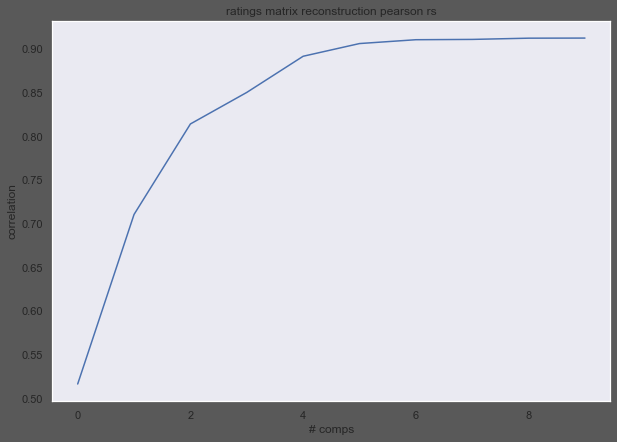

In [105]:
plot_ys = no_holdout_colcors.groupby('num_pcs').mean().reset_index().correlation
fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(10),plot_ys)
plt.title('ratings matrix reconstruction pearson rs')
plt.xlabel('# comps')
plt.ylabel('correlation')

<BarContainer object of 30 artists>

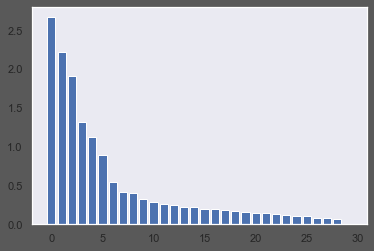

In [106]:
plt.bar(np.arange(30),S)

In [107]:
# cors= []

# conc_prof_mat_C = np.zeros(shape = (30,8))

# ratings.loc[:, ratings.columns != 'V'+str(51)]
# for this_color in range(1,59):
#     for i in range(ratings.shape[0]):
#         column_name = 'V'+str(this_color)
#         ratings_sub = ratings.loc[:, ratings.columns != column_name]
#         ratings_sub = ratings_sub.iloc[:,1:]
#         concept_ratings = np.array(ratings_sub)-c_means[c_means.iloc[:,0]!=this_color].V1.values
#         A = pd.read_csv('../../data/basis_vecs_scaled_color_{}.csv'.format(this_color))
#         A = np.array(A)
#         A = np.delete(A, 0, axis=1)
#         A_8 = A[:,0:8]
        
#         reg = lm.LinearRegression().fit(A_8, concept_ratings.T)
#         coords = reg.coef_[0:8]
#         recon = np.matmul(A_8,coords)

    #cors.append(np.corrcoef(recon.astype(float),concept_ratings.squeeze(0).astype(float))[0,1])

    

In [108]:
### So here we're holding out one color at a time and trying to estimate concept ratings for each of the holdouts



# conc_prof_mats = []
# for this_color in range(1,59):
#     conc_prof_mat_C = np.zeros(shape=(30,5))
#     A = pd.read_csv('../../data/basis_vecs_scaled_color_{}.csv'.format(this_color))
#     A = np.array(A)
#     #A_8 = A[:,0:8]
#     for i in range(ratings.shape[0]):
        
#         column_name = 'V'+str(this_color)
#         concept_ratings = ratings.loc[:,ratings.columns != column_name]
#         concept_ratings = concept_ratings.iloc[i][1:]
#         concept_ratings = np.array(concept_ratings)
#         concept_ratings = concept_ratings-c_means[c_means.index!=(this_color-1)].V1.values
        
        
#         reg = lm.LinearRegression().fit(A[:,:5], concept_ratings)
#         coords = reg.coef_[0:5]
#         recon = np.matmul(A[:,:5],coords)
#         conc_prof_mat_C[i,:] = coords
#     #conc_prof_mats.append(conc_prof_mat_C)
    


In [109]:
color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy()
cors = []
for i in range(1,59):
    ratings_sub = ratings.iloc[:,1:] ## removing label column
    ratings_sub = ratings_sub.iloc[:,i-1] ## selecting column of holdout color
    
    #this_conc_prof_mat = conc_prof_mats[i-1]
    #this_conc_prof_mat = pd.read_csv('../../data/left_8_vec_color_{}.csv'.format(i)).to_numpy()[:,1:]
    this_conc_prof_mat = pd.read_csv('../../data/left_8_vec_color_{}.csv'.format(i)).to_numpy()[:,:5]
    this_prof_coef_mat = pd.read_csv('../../data/8_regression_weights_color_{}.csv'.format(i), header=None).to_numpy()[:,:5]
    recon = np.matmul(np.matmul(this_conc_prof_mat,this_prof_coef_mat.T),color_coord_mat)+c_means.V1.values
    cors.append(np.corrcoef(recon[:,i-1],ratings_sub)[0,1])
    

In [110]:
colcors = pd.DataFrame(list(zip(list(range(1,59)),cors)), columns = ['color','holdout_correlation'])
uw58rgb = pd.read_csv('../../data/UW_58_rgb.csv', header=None)
colcors = pd.concat([colcors, uw58rgb], axis=1)
colcors = colcors.sort_values(['holdout_correlation'],ascending=False).reset_index(drop=True)

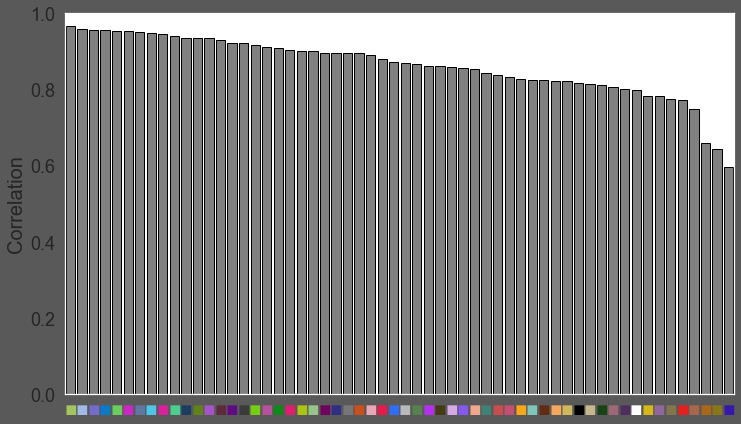

In [111]:
import matplotlib.font_manager as mfm

font_path = 'FreeSerif.ttf'
prop = mfm.FontProperties(fname=font_path)


#colcors = colcors.sort_values(['holdout_correlation'],ascending=False).reset_index(drop=True)
fig = plt.figure(figsize=(12,7))
sns.barplot(colcors.index, colcors.holdout_correlation, edgecolor = 'black', color='gray')
#plt.axis('off')
#plt.xticks([])
#plt.xticks(rotation = 90, fontsize= 16)
plt.xlabel('')
plt.yticks(fontsize=18)
plt.ylabel('Correlation', fontsize=20)
plt.ylim(0,1)
ax = plt.gca()
#ax.set_facecolor((0.3497,0.3497,0.3497))
ax.set_facecolor((1,1,1))
symbolsx = [u"■"]*colcors.shape[0]
ax.set_xticks(range(len(symbolsx)))
ax.set_xticklabels(symbolsx, fontproperties=prop, fontsize=14)
for tick, color in zip(ax.get_xticklabels(), sns.color_palette(list(zip(colcors[0],colcors[1],colcors[2])))):
    tick.set_color(color)

#plt.savefig('color_holdout.pdf',format ='pdf',bbox_inches='tight')
plt.show()


In [112]:
np.mean(cors)

0.8630759214904336

## Let's vary both num pc and the holdout

In [113]:
num_pcs =[]
cors = []
col_reg_cors = []
col_num = []
for num_pc in range(9):

    prof_coef_mat = pd.read_csv(f'../../data/{num_pc+1}_regression_weights.csv', header=None).to_numpy()
    color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy()

    recon = np.matmul(conc_prof_mat[:,:(num_pc+1)],np.matmul((prof_coef_mat.T)[:(num_pc+1),],color_coord_mat)).T
    recon = recon+c_means.V1.values.reshape(58,1)
    recon = recon.T
 
    for i in range(1,59):
        ratings_sub = ratings.iloc[:,1:] ## removing label column
        ratings_sub = ratings_sub.iloc[:,i-1] ## selecting column of holdout color
        
        #this_conc_prof_mat = conc_prof_mats[i-1]
        #this_conc_prof_mat = pd.read_csv('../../data/left_8_vec_color_{}.csv'.format(i)).to_numpy()[:,1:]
        this_conc_prof_mat = pd.read_csv('../../data/left_8_vec_color_{}.csv'.format(i)).to_numpy()[:,:num_pc]
        this_prof_coef_mat = pd.read_csv('../../data/8_regression_weights_color_{}.csv'.format(i), header=None).to_numpy()[:,:num_pc]
        recon = np.matmul(np.matmul(this_conc_prof_mat,this_prof_coef_mat.T),color_coord_mat)+c_means.V1.values
        cors.append(np.corrcoef(recon[:,i-1],ratings_sub)[0,1])
        num_pcs.append(num_pc+1)
        col_num.append(i)



In [114]:
holdout_col_cors= pd.DataFrame(list(zip(cors,num_pcs,col_num)), columns=['correlation','#_pc','holdout_col'])

Text(0, 0.5, 'correlation')

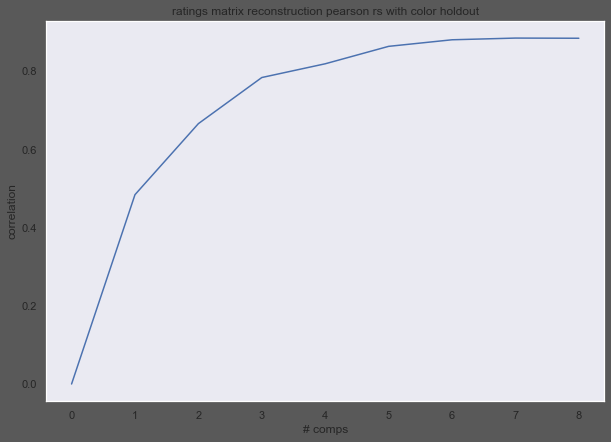

In [115]:
plot_ys = holdout_col_cors.groupby('#_pc').mean().reset_index().correlation
plt.figure(figsize=(10,7))
plt.plot(np.arange(9),plot_ys)
plt.title('ratings matrix reconstruction pearson rs with color holdout')
plt.xlabel('# comps')
plt.ylabel('correlation')

In [116]:
uw58map = sns.color_palette(list(zip(uw58rgb[0],uw58rgb[1],uw58rgb[2])))

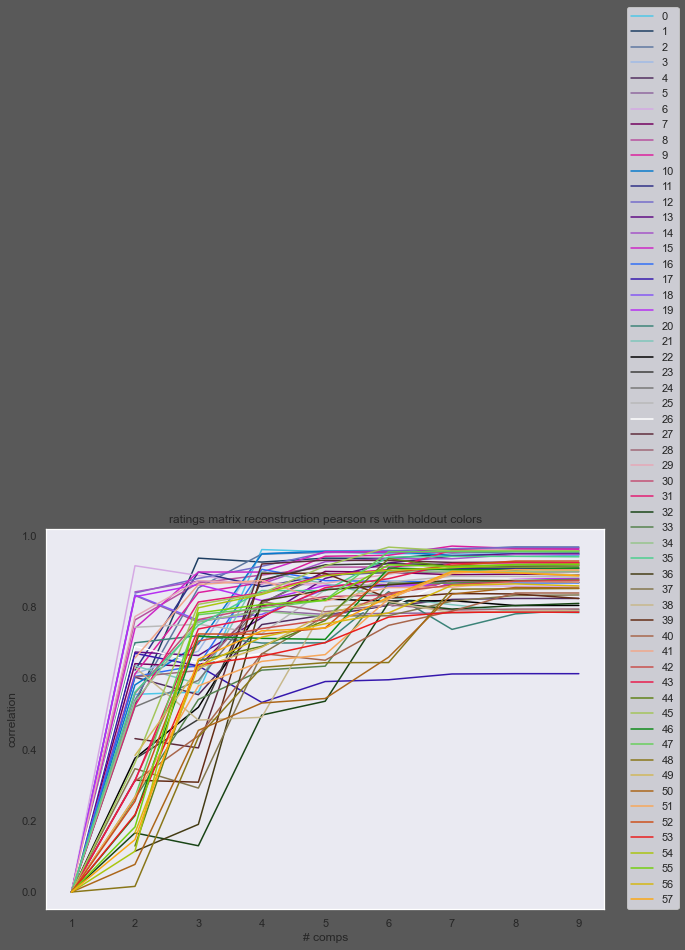

In [117]:
plt.figure(figsize=(10,7))
for i in range(58):
    plot_ys = holdout_col_cors[holdout_col_cors.holdout_col==i+1].correlation
    plt.plot(np.arange(1,10),plot_ys, label=i, color=uw58map[i])
    plt.title('ratings matrix reconstruction pearson rs with holdout colors')
    plt.xlabel('# comps')
    plt.ylabel('correlation')
    plt.legend(loc=(1.04,0))
plt.show()

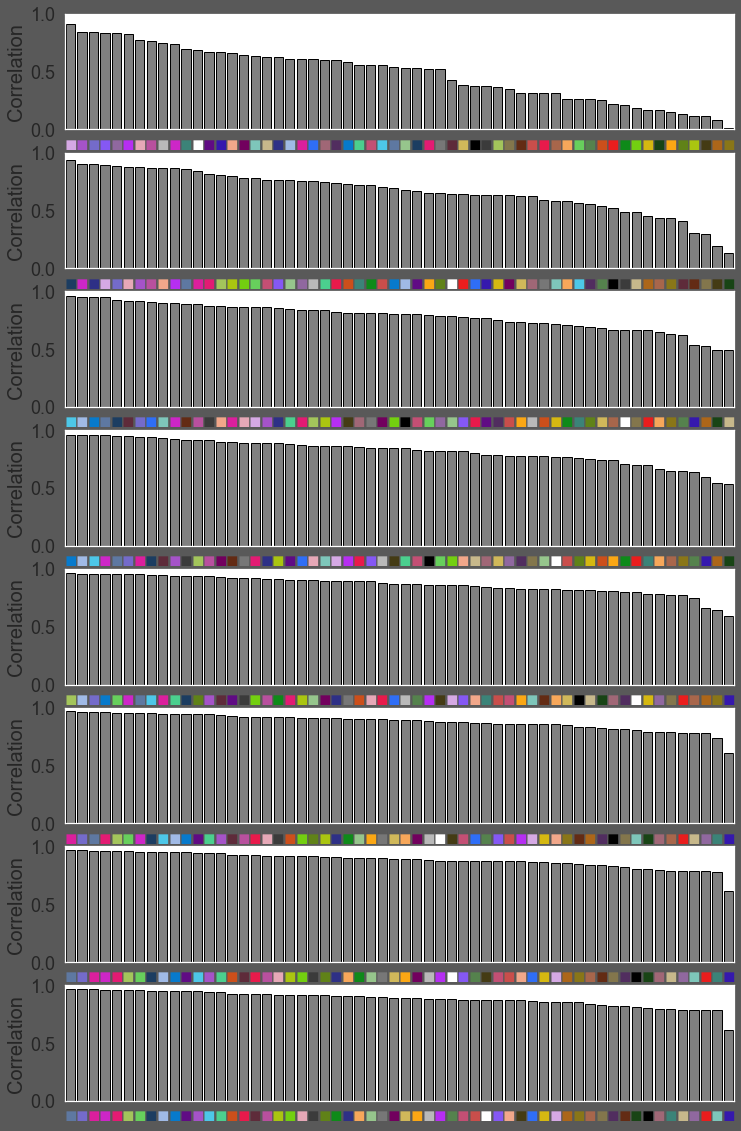

In [118]:

fig, ax = plt.subplots(8,1, figsize=(12,20))

for i in range(2,10):
    

    colcors = holdout_col_cors[holdout_col_cors['#_pc']==i].reset_index(drop=True)
    uw58rgb = pd.read_csv('../../data/UW_58_rgb.csv', header=None)
    colcors = pd.concat([colcors, uw58rgb], axis=1)
    colcors = colcors.sort_values(['correlation'],ascending=False).reset_index(drop=True)


    sns.barplot(ax=ax[i-2],x= colcors.index, y= colcors.correlation, edgecolor = 'black', color='gray')
    #plt.axis('off')
    #plt.xticks([])
    #plt.xticks(rotation = 90, fontsize= 16)
    ax[i-2].set_xlabel('')
    ax[i-2].tick_params(axis='y',labelsize=18)
    ax[i-2].set_ylabel('Correlation', fontsize=20)
    ax[i-2].set_ylim(0,1)
    #ax = plt.gca()
    #ax.set_facecolor((0.3497,0.3497,0.3497))
    ax[i-2].set_facecolor((1,1,1))
    symbolsx = [u"■"]*colcors.shape[0]
    ax[i-2].set_xticks(range(len(symbolsx)))
    ax[i-2].set_xticklabels(symbolsx, fontproperties=prop, fontsize=14)
    for tick, color in zip(ax[i-2].get_xticklabels(), sns.color_palette(list(zip(colcors[0],colcors[1],colcors[2])))):
        tick.set_color(color)

    #plt.savefig('color_holdout.pdf',format ='pdf',bbox_inches='tight')
    #plt.show()


In [119]:
ax[2]

<AxesSubplot:ylabel='Correlation'>

In [120]:
color_coord_mat = pd.read_csv('../../data/uw58_regressor_vals.csv',header=None).to_numpy()
cors = []
for i in range(1,59):
    ratings_sub = ratings.iloc[:,1:] ## removing label column
    ratings_sub = ratings_sub.iloc[:,i-1] ## selecting column of holdout color
    
    #this_conc_prof_mat = conc_prof_mats[i-1]
    #this_conc_prof_mat = pd.read_csv('../../data/left_8_vec_color_{}.csv'.format(i)).to_numpy()[:,1:]
    this_conc_prof_mat = pd.read_csv('../../data/left_8_vec_color_{}.csv'.format(i)).to_numpy()[:,:5]
    this_prof_coef_mat = pd.read_csv('../../data/8_regression_weights_color_{}.csv'.format(i), header=None).to_numpy()[:,:5]
    recon = np.matmul(np.matmul(this_conc_prof_mat,this_prof_coef_mat.T),color_coord_mat)+c_means.V1.values
    cors.append(np.corrcoef(recon[:,i-1],ratings_sub)[0,1])
    

In [100]:
v_sub.shape

(5, 58)

## Plotting Profiles

In [121]:
v_sub_df = pd.DataFrame(v_sub.T, columns=['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10'])
v_sub_df = pd.concat([v_sub_df, uw58rgb],axis=1)





In [122]:
components

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

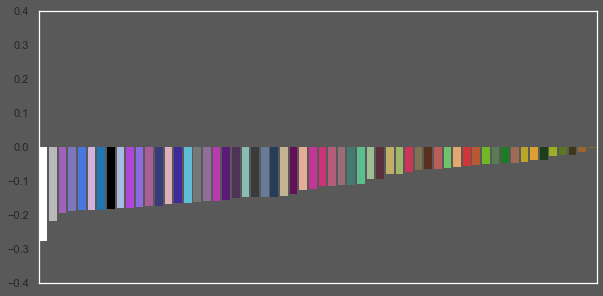

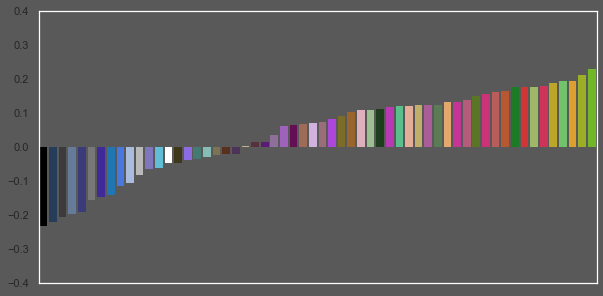

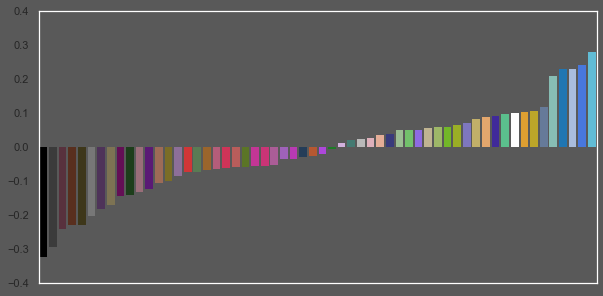

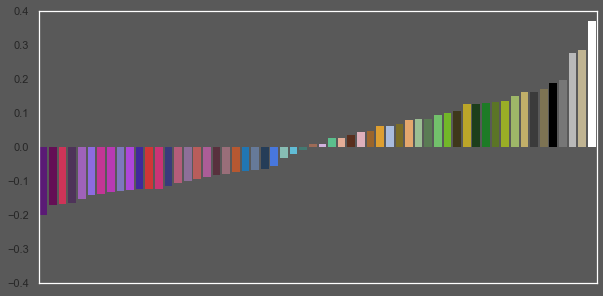

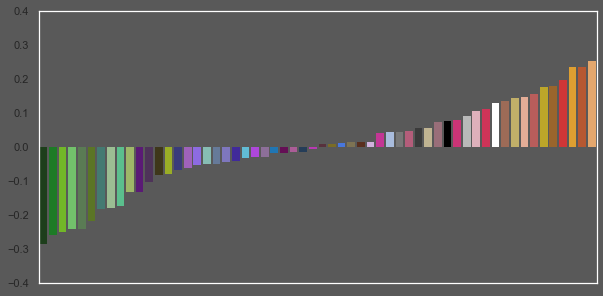

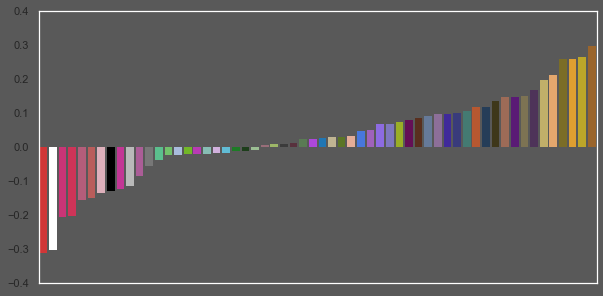

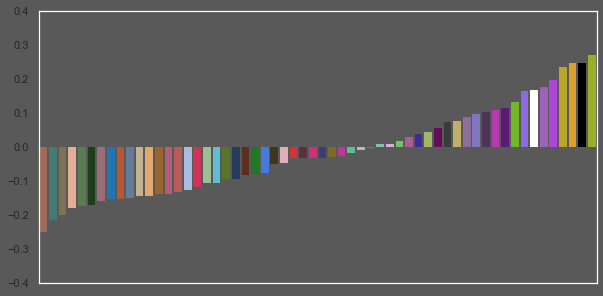

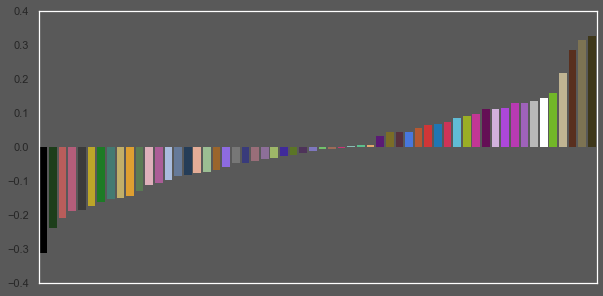

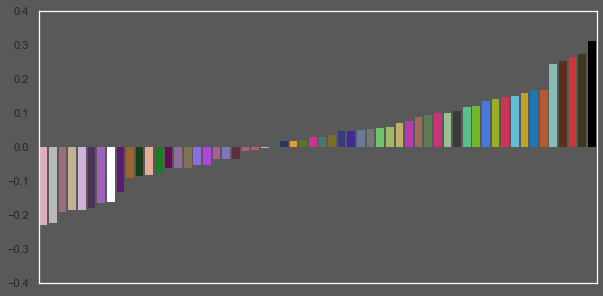

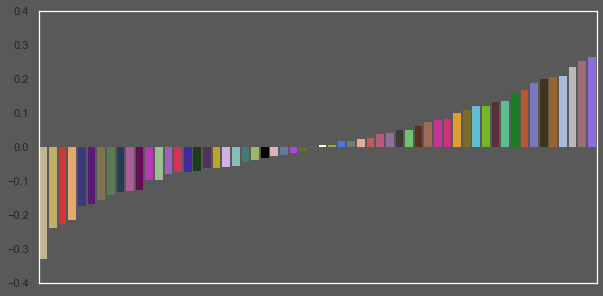

In [123]:
components = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']

for i in range(len(components)):
    sns.set(rc={'figure.facecolor':(0.3497,0.3497,0.3497),
               'axes.grid':False})
    plt.figure(figsize=(10,5))


    plotdf = v_sub_df.sort_values([str(components[i])]).reset_index(drop=True)
    fig = sns.barplot(plotdf.index, plotdf[components[i]], edgecolor = 'none',palette = sns.color_palette(list(zip(plotdf[0],plotdf[1],plotdf[2]))))
    #plt.axis('off')
    plt.xticks([])
    plt.ylabel('')
    plt.ylim(-0.4,0.4)
    ax = plt.gca()
    ax.set_facecolor((0.3497,0.3497,0.3497))
    
    plt.savefig('component_{}.pdf'.format(i))
    plt.show()
    

In [97]:
#Reconstructed ratings from matlab

In [123]:
reg_preds= pd.read_csv('../../data/regression_predictions.csv',header=None)
reg_preds = np.array(reg_preds)[:5,:]
reg_preds_df = pd.DataFrame(reg_preds.T, columns=['C1','C2','C3','C4','C5'])
reg_preds_df = pd.concat([reg_preds_df, uw58rgb],axis=1)

In [ ]:


for i in range(len(components)):
    sns.set(rc={'figure.facecolor':(0.3497,0.3497,0.3497),
               'axes.grid':False})
    plt.figure(figsize=(10,5))


    plotdf = reg_preds_df.sort_values([str(components[i])]).reset_index(drop=True)
    fig = sns.barplot(plotdf.index, plotdf[components[i]], edgecolor = 'none',palette = sns.color_palette(list(zip(plotdf[0],plotdf[1],plotdf[2]))))
    #plt.axis('off')
    plt.xticks([])
    plt.ylabel('')
    plt.ylim(-0.4,0.4)
    ax = plt.gca()
    ax.set_facecolor((0.3497,0.3497,0.3497))
    
    plt.savefig('pred_component_{}.pdf'.format(i))
    plt.show()

In [ ]:
color_reg_cors=[]
for i in range(8):
    color_reg_cors.append(np.corrcoef(v_sub[i,:],reg_preds[i,:])[0,1])
color_reg_cors

In [ ]:
#fig = plt.figure()
sns.set(rc={'figure.facecolor':(1,1,1),
               'axes.grid':False})
fig = sns.palplot(uw58rgb.to_numpy())
#fig.get_figure()
#fig.savefig('uw58pal.pdf')

In [ ]:
fig

In [ ]:
U_concepts = [ "dress"  ,    "pants" ,     "shirt"   ,   "shoes"  ,    "socks"   ,   "above"  ,    "below"   ,   "beside"  ,  
"far"     ,   "near"    ,   "angry"    ,  "disgust"  ,  "fearful" ,   "happy"   ,   "sad"  ,      "blueberry" ,
 "lemon"    ,  "mango"  ,    "strawberry" ,"watermelon" ,"beach"   ,   "field"   ,   "ocean"   ,   "sky" ,      
 "sunset"  ,   "dawn"  ,     "day"   ,     "dusk"  ,     "night"    ,  "noon"]       

In [ ]:
for i in range(U.shape[0]):
    print(U[i,0:8])

In [ ]:

    
U_ratings = U[:,0:8]

U_ratings = U_ratings - U_ratings.mean(axis=0)
U_ratings = U_ratings / np.abs(U_ratings).max(axis=0)



In [ ]:
U_ratings_df = pd.DataFrame(U_ratings)

In [ ]:
U_ratings_df['concept']= U_concepts

In [ ]:
from numpy import eye, asarray, dot, sum, diagx
def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in xrange(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R)

In [ ]:
sns.color_palette(list(zip(colcors[0],colcors[1],colcors[2])))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
fig = plt.figure(figsize=(7,5))
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.edgecolor":     'black',
    "axes.facecolor":    (1, 1, 1),  # green with alpha = 50%
    "axes.spines.left":   True,
     "axes.spines.bottom": True
#axes.spines.top:    True
#axes.spines.right:  True"
})
mu = .1
variance = (1.4*(mu)*(1-mu))**2
sigma = math.sqrt(variance)
x = np.linspace(mu - 7*sigma, mu + 7*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color="#F0A78A", linewidth=3)
plt.xlim(0,1)
plt.xticks(fontsize=16)
plt.yticks([])
plt.xlabel("Association Rating", fontsize=18)
plt.ylabel("Density", fontsize=18)
plt.grid(False)
plt.show()